In [1750]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
from datetime import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from scipy import stats
import math
from PIL import Image
from sklearn import metrics
import pickle



Functions

In [1751]:
#Cleaning Data
def fill_na(df):
    df.fillna(df.median(), inplace= True)
def clean(df):
    df["sqft_basement"] = df["sqft_basement"].replace("?","0").astype(float)
    df["waterfront"] = df["waterfront"].fillna("NO")
    df["view"] = df["view"].fillna("NONE")
    df["yr_renovated"] = df["yr_renovated"].fillna(np.nan)
    df['house_age'] = df['yr_built'].map(lambda x: 2022-x)
    df["bedrooms"] = df["bedrooms"].replace(33,3)

def date_prep(df):
    df['year_sold'] = df['date'].map(lambda x: x[-4:])
    df['month'] = df['date'].map(lambda x: x[0:2])
    df['month'] = df['month'].map(lambda x: x.replace('/',''))
    df['month'] = df['month'].astype(int)
    df['year_sold'] = df['year_sold'].astype(int)

def date_bins(df):    
    bins = [0, 3, 6, 9, 12]
    date_bins = pd.cut(df['month'], bins, include_lowest=True, labels=['Winter', 'Spring', 'Summer', 'Fall'])
    date_bins = date_bins.cat.as_unordered()
    df["season"] = date_bins
    df = df.drop(["month","date"], axis = 1, inplace= True)

#Function to convert categorical data 
def convert_categorical(column_names):
    for column_name in column_names:
        df[column_name] = pd.Categorical(df[column_name])
        df[column_name] = df[column_name].cat.codes

def OLS_reg(df):
    y = df["price"]
    X = df.drop("price", axis=1)
    model = sm.OLS(y, sm.add_constant(X), missing = "drop").fit()
    results = model.summary()
    print(results)

def data_cleaning(df):
    df = df[(df["price"] > 100000) & (df["price"]< 1500000)]
    df = df[(np.abs(stats.zscore(df["sqft_living"])) < 3)]
    df = (df[df["bedrooms"] < 7])
    df = (df[df["bathrooms"] < 6])
    df = (df[df["sqft_living"] < 8000])

def predictive_model(df):
    df2 = df.to_numpy()
    y = df2[:, 0]
    X = df2[:,1:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    data_transformation = preprocessing.StandardScaler()
    data = data_transformation.fit_transform(X_train)
    model = LinearRegression().fit(data, y_train)
    accuracy = model.score(data, y_train)
    test_accuracy = model.score(data_transformation.transform((X_test)), y_test)
    y_pred = model.predict(data_transformation.transform(X_test))
    print("X_train shape", X_train.shape)
    print("X_test shape",X_test.shape)
    print("y_train shape",y_train.shape)
    print("y_test shape",y_test.shape)
    print("Accuracy R^2",accuracy)
    print("Test_accuracy R^2",test_accuracy)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    model = pd.DataFrame({'Actual value': y_test, 'Predicted value': (y_pred.round(2)), "Difference" : (abs(y_test-y_pred)).round(2)})
    print(model.sample(10).head(10))
    true_value = model["Actual value"]
    predicted_value = model["Predicted value"]
    plt.figure(figsize=(20,20))
    plt.scatter(true_value, predicted_value, c='crimson')
    plt.yscale('log')
    plt.xscale('log')
    p1 = min(min(predicted_value), min(true_value))
    p2 = max(max(predicted_value), max(true_value))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('Predictions''True Values', fontsize=15)
    plt.ylabel('True Values', fontsize=15)
    plt.axis('equal')
    plt.show()

def poly_model(df):
    df2 = df.to_numpy()
    y = df2[:, 0]
    X = df2[:,1:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    data_transformation = preprocessing.StandardScaler()
    data = data_transformation.fit_transform(X_train)
    model = LinearRegression().fit(data, y_train)
    for index, degree in enumerate([2,3]):
    
    # Instantiate PolynomialFeatures
        poly = PolynomialFeatures(degree)
    
    # Fit and transform X_train
        X_poly_train = poly.fit_transform(X_train)
    
    # Instantiate and fit a linear regression model to the polynomial transformed train features
        reg_poly = LinearRegression().fit(X_poly_train, y_train)
    
    # Transform the test data into polynomial features
        X_poly_test = poly.transform(X_test)
    
    # Get predicted values for transformed polynomial test data  
        y_pred = reg_poly.predict(X_poly_test)
    
    # Evaluate model performance on test data
        print("degree %d" % degree, r2_score(y_test, y_pred))
    
    # Transform the full data
        X_poly = poly.transform(X)
    
    # Now, we want to see what the model predicts for the entire data  
        y_poly = reg_poly.predict(X_poly)

In [1752]:
#Importing Data
#Read dataset
pd.set_option('display.max_columns', None)
df1 = pd.read_csv("data/kc_house_data.csv", index_col="id")
df_income = pd.read_csv("data/dc_housing_income_by_zip.csv")#source https://www.kaggle.com/miker400/washington-state-home-mortgage-hdma2016?select=Washington_State_HDMA-2016.csv


In [1753]:
#Using median income per zipcode
income = df_income.groupby("zipcode").median().round()

In [1754]:
#Keeping last value in dataset
df1 = df1[~df1.index.duplicated(keep='last')]

In [1755]:
#Merging datasets on zipcode
df = df1.merge(income, on ="zipcode")

In [1756]:
#Exploring data
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Income
count,2.142000e+04,21420.000000,21420.000000,21420.000000,2.142000e+04,21420.000000,21420.000000,21420.000000,17607.000000,21420.00000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000
mean,5.418614e+05,3.373950,2.118429,2083.132633,1.512804e+04,1.495985,1791.170215,1971.092997,83.890101,98077.87437,47.560197,-122.213784,1988.384080,12775.718161,144053.110317
std,3.675569e+05,0.925405,0.768720,918.808412,4.153080e+04,0.540081,828.692965,29.387141,400.534473,53.47748,0.138589,0.140791,685.537057,27345.621867,59197.423590
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.00000,47.155900,-122.519000,399.000000,651.000000,7190.000000
25%,3.249500e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1200.000000,1952.000000,0.000000,98033.00000,47.471200,-122.328000,1490.000000,5100.000000,98190.000000
50%,4.505500e+05,3.000000,2.250000,1920.000000,7.614000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.00000,47.572100,-122.230000,1840.000000,7620.000000,141286.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.069050e+04,2.000000,2220.000000,1997.000000,0.000000,98117.00000,47.678100,-122.125000,2370.000000,10086.250000,190960.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.00000,47.777600,-121.315000,6210.000000,871200.000000,277894.000000


The information above tells us waterfront, view, and  yr_renovated 

In [1757]:
#Running functions to fill numerical columns with median value
fill_na(df)

In [1758]:
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Income
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,113555.0
1,6/23/2014,205425.0,2,1.00,880,6780,1.0,NO,NONE,Good,6 Low Average,880,0.0,1945,0.0,98178,47.5009,-122.248,1190,6780,113555.0
2,7/17/2014,445000.0,3,2.25,2100,8201,1.0,NaN,AVERAGE,Average,8 Good,1620,480.0,1967,0.0,98178,47.5091,-122.244,2660,8712,113555.0
3,9/25/2014,236000.0,3,1.00,1300,5898,1.0,NaN,NONE,Average,7 Average,1300,0.0,1961,0.0,98178,47.5053,-122.255,1320,7619,113555.0
4,2/27/2015,170000.0,2,1.00,860,5265,1.0,NO,NONE,Average,6 Low Average,860,0.0,1931,0.0,98178,47.5048,-122.272,1650,8775,113555.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21415,10/3/2014,2720000.0,4,3.25,3990,18115,2.0,NO,NONE,Good,11 Excellent,3990,0.0,1989,0.0,98039,47.6177,-122.229,3450,16087,7190.0
21416,7/25/2014,1950000.0,4,3.50,4065,18713,2.0,NO,NONE,Good,10 Very Good,4065,0.0,1987,0.0,98039,47.6209,-122.237,3070,18713,7190.0
21417,4/21/2015,2250000.0,5,5.25,3410,8118,2.0,NaN,NONE,Average,11 Excellent,3410,0.0,2006,0.0,98039,47.6295,-122.236,3410,16236,7190.0
21418,11/13/2014,2900000.0,5,4.00,5190,14600,2.0,NO,FAIR,Average,11 Excellent,5190,0.0,2013,0.0,98039,47.6102,-122.225,3840,19250,7190.0


In [1759]:
#Running functions to change date to usable format and bin dates into seasons
date_prep(df)
date_bins(df)

In [1760]:
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Income,year_sold,season
0,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,113555.0,2014,Fall
1,205425.0,2,1.00,880,6780,1.0,NO,NONE,Good,6 Low Average,880,0.0,1945,0.0,98178,47.5009,-122.248,1190,6780,113555.0,2014,Spring
2,445000.0,3,2.25,2100,8201,1.0,NaN,AVERAGE,Average,8 Good,1620,480.0,1967,0.0,98178,47.5091,-122.244,2660,8712,113555.0,2014,Summer
3,236000.0,3,1.00,1300,5898,1.0,NaN,NONE,Average,7 Average,1300,0.0,1961,0.0,98178,47.5053,-122.255,1320,7619,113555.0,2014,Summer
4,170000.0,2,1.00,860,5265,1.0,NO,NONE,Average,6 Low Average,860,0.0,1931,0.0,98178,47.5048,-122.272,1650,8775,113555.0,2015,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21415,2720000.0,4,3.25,3990,18115,2.0,NO,NONE,Good,11 Excellent,3990,0.0,1989,0.0,98039,47.6177,-122.229,3450,16087,7190.0,2014,Fall
21416,1950000.0,4,3.50,4065,18713,2.0,NO,NONE,Good,10 Very Good,4065,0.0,1987,0.0,98039,47.6209,-122.237,3070,18713,7190.0,2014,Summer
21417,2250000.0,5,5.25,3410,8118,2.0,NaN,NONE,Average,11 Excellent,3410,0.0,2006,0.0,98039,47.6295,-122.236,3410,16236,7190.0,2015,Spring
21418,2900000.0,5,4.00,5190,14600,2.0,NO,FAIR,Average,11 Excellent,5190,0.0,2013,0.0,98039,47.6102,-122.225,3840,19250,7190.0,2014,Fall


In [1761]:
#Saving changed to csv
df.to_csv("data/kc_house_data_no_miss_values.csv")

In [1762]:
df.dtypes

price             float64
bedrooms            int64
bathrooms         float64
sqft_living         int64
sqft_lot            int64
floors            float64
waterfront         object
view               object
condition          object
grade              object
sqft_above          int64
sqft_basement      object
yr_built            int64
yr_renovated      float64
zipcode             int64
lat               float64
long              float64
sqft_living15       int64
sqft_lot15          int64
Income            float64
year_sold           int32
season           category
dtype: object

In [1763]:
#Converting sqft_basement to float
df["sqft_basement"] = df["sqft_basement"].replace("?","0").astype(float)

In [1764]:
convert_categorical(["bedrooms","bathrooms","floors","waterfront","view","condition","season","grade",'zipcode',])

In [1765]:
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Income,year_sold,season
0,221900.0,2,2,1180,5650,0,-1,4,0,8,1180,0.0,1955,0.0,66,47.5112,-122.257,1340,5650,113555.0,2014,3
1,205425.0,1,2,880,6780,0,0,4,2,7,880,0.0,1945,0.0,66,47.5009,-122.248,1190,6780,113555.0,2014,1
2,445000.0,2,7,2100,8201,0,-1,0,0,9,1620,480.0,1967,0.0,66,47.5091,-122.244,2660,8712,113555.0,2014,2
3,236000.0,2,2,1300,5898,0,-1,4,0,8,1300,0.0,1961,0.0,66,47.5053,-122.255,1320,7619,113555.0,2014,2
4,170000.0,1,2,860,5265,0,0,4,0,7,860,0.0,1931,0.0,66,47.5048,-122.272,1650,8775,113555.0,2015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21415,2720000.0,3,11,3990,18115,2,0,4,2,1,3990,0.0,1989,0.0,24,47.6177,-122.229,3450,16087,7190.0,2014,3
21416,1950000.0,3,12,4065,18713,2,0,4,2,0,4065,0.0,1987,0.0,24,47.6209,-122.237,3070,18713,7190.0,2014,2
21417,2250000.0,4,19,3410,8118,2,-1,4,0,1,3410,0.0,2006,0.0,24,47.6295,-122.236,3410,16236,7190.0,2015,1
21418,2900000.0,4,14,5190,14600,2,0,2,0,1,5190,0.0,2013,0.0,24,47.6102,-122.225,3840,19250,7190.0,2014,3


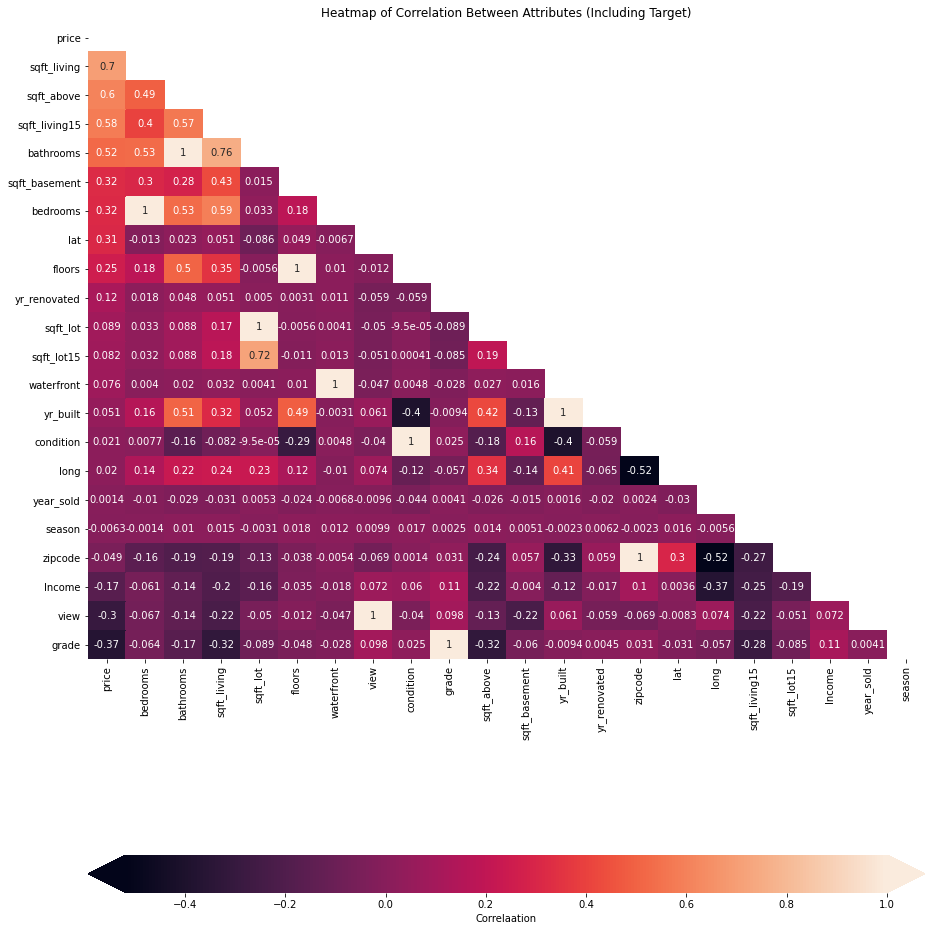

In [1766]:
initial_corr = df.corr().sort_values(by="price", ascending=False)
fig, ax = plt.subplots(figsize=(15,18))
sns.heatmap(data = initial_corr, mask = np.triu(np.ones_like(initial_corr, dtype=bool)), ax = ax, annot = True, cbar_kws = {"label": "Correlaation", "orientation": "horizontal", "pad": .2, "extend": "both"})

ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [1767]:
high_corr_formula = 'price ~ sqft_living'
high_corr_formula = ols(formula=high_corr_formula, data=df).fit()
singular_model = high_corr_formula.summary()
print(singular_model)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                 2.073e+04
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        01:10:55   Log-Likelihood:            -2.9763e+05
No. Observations:               21420   AIC:                         5.953e+05
Df Residuals:                   21418   BIC:                         5.953e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.255e+04   4436.470     -9.591      

In [1768]:
first_model = OLS_reg(df)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     2002.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        01:10:55   Log-Likelihood:            -2.9324e+05
No. Observations:               21420   AIC:                         5.865e+05
Df Residuals:                   21398   BIC:                         5.867e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.411e+08   9.61e+06    -14.671

X_train shape (17136, 21)
X_test shape (4284, 21)
y_train shape (17136,)
y_test shape (4284,)
Accuracy R^2 0.6659210060899786
Test_accuracy R^2 0.6470842860227771
Mean Absolute Error: 134983.68179545863
Mean Squared Error: 44180762173.723946
Root Mean Squared Error: 210192.20293275377
      Actual value  Predicted value  Difference
2905      292000.0        271330.37    20669.63
1341     1010000.0        735628.05   274371.95
3970      419600.0        505893.18    86293.18
3332      525000.0        694234.15   169234.15
2897      650000.0        626779.04    23220.96
585       760000.0        993985.60   233985.60
1327      450000.0        527251.53    77251.53
1843      920000.0       1012023.03    92023.03
4048      250000.0        311149.27    61149.27
3885      235000.0        189576.08    45423.92


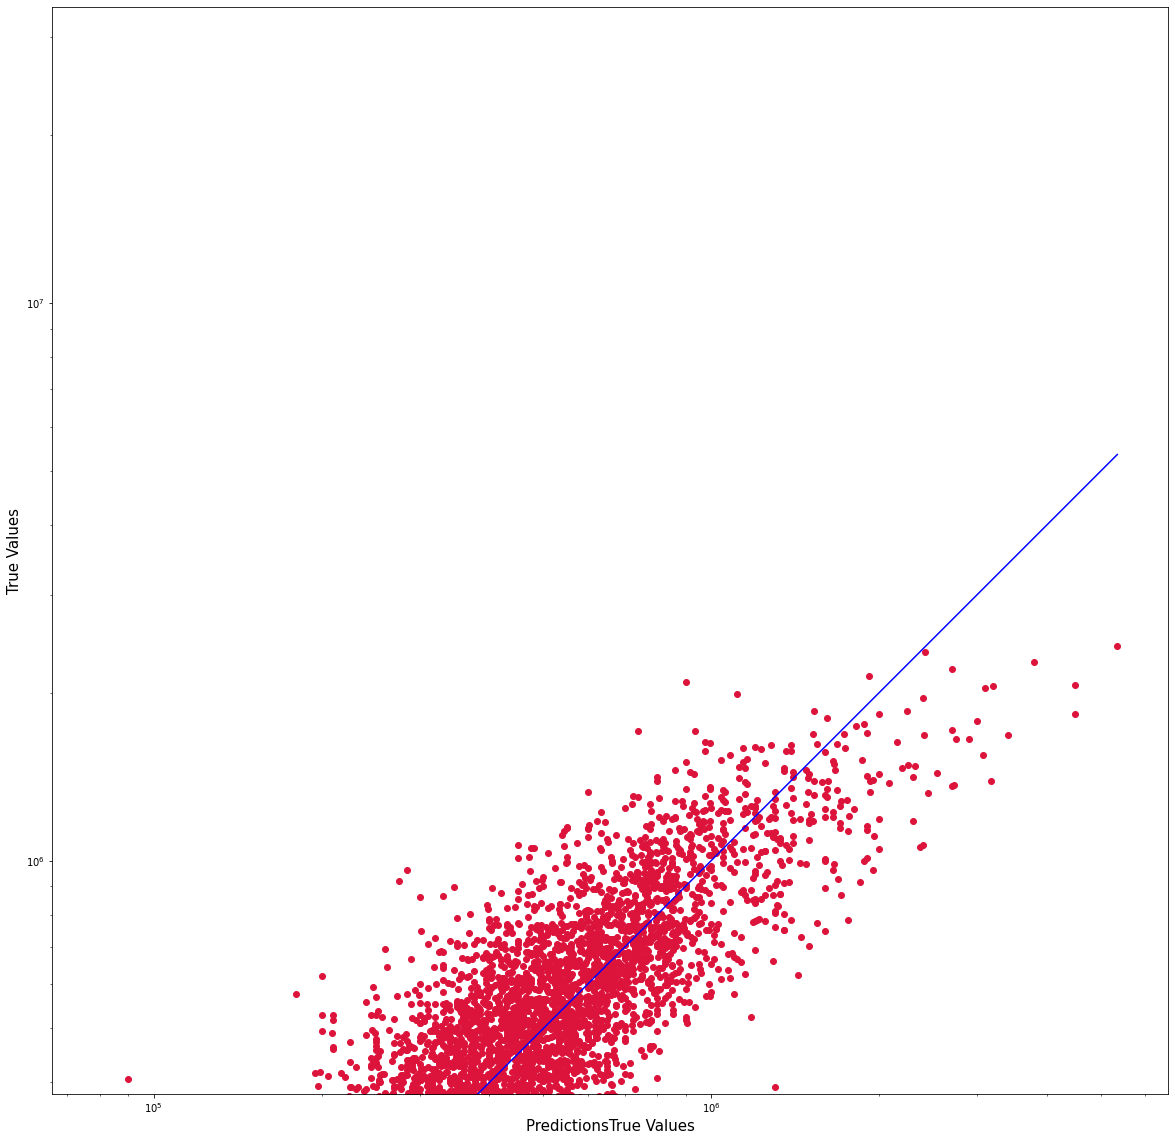

In [1769]:
#First Predictive model
predictive_model(df)

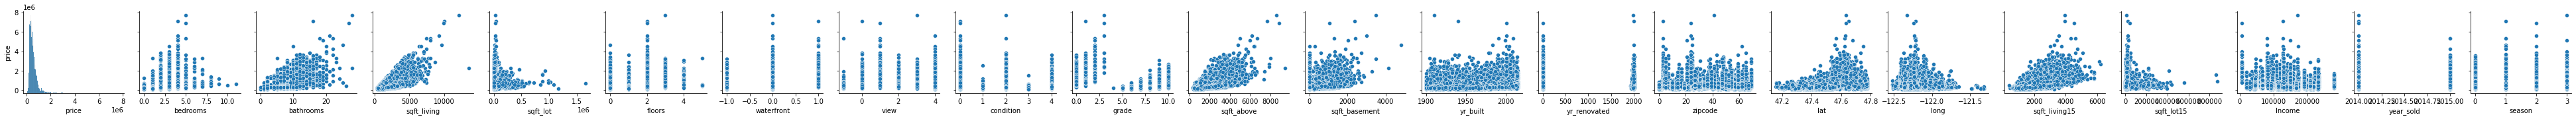

In [1770]:
sns.pairplot(df, y_vars="price")

As we can see from the charts there are some outliers that need to be addressed, after the outliers are addressed we will also need to log tranform some of our data to turn into normal distribution

<AxesSubplot:>

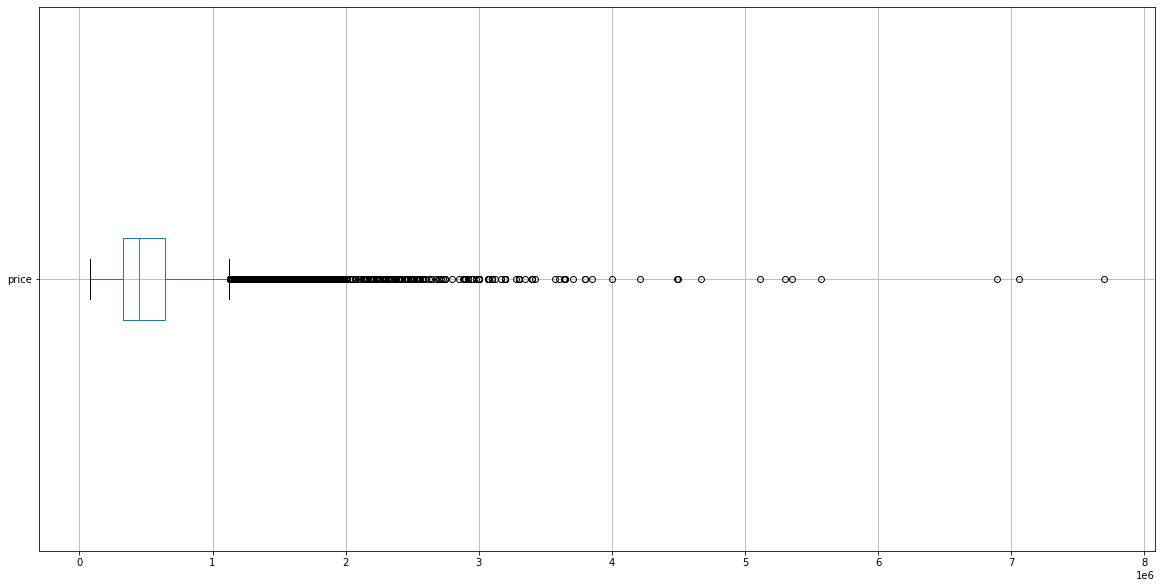

In [1771]:
df.boxplot('price', vert=False, figsize=(20,10))

In [1772]:
df = df[df["price"] < 1500000]

<AxesSubplot:>

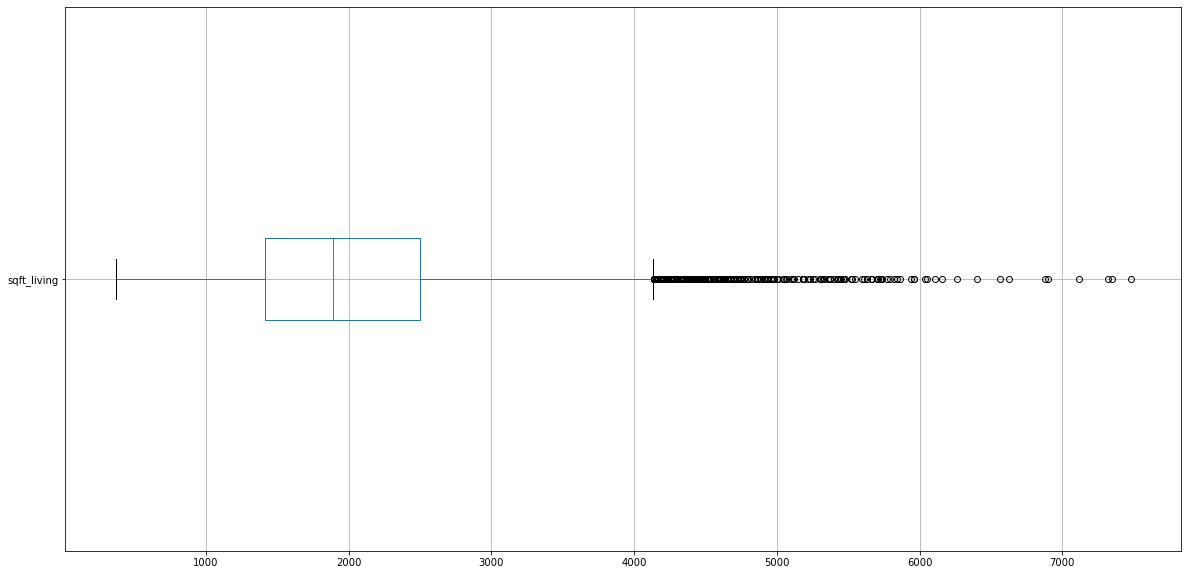

In [1773]:
df.boxplot('sqft_living', vert=False, figsize=(20,10))

In [1774]:
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Income,year_sold,season
0,221900.0,2,2,1180,5650,0,-1,4,0,8,1180,0.0,1955,0.0,66,47.5112,-122.257,1340,5650,113555.0,2014,3
1,205425.0,1,2,880,6780,0,0,4,2,7,880,0.0,1945,0.0,66,47.5009,-122.248,1190,6780,113555.0,2014,1
2,445000.0,2,7,2100,8201,0,-1,0,0,9,1620,480.0,1967,0.0,66,47.5091,-122.244,2660,8712,113555.0,2014,2
3,236000.0,2,2,1300,5898,0,-1,4,0,8,1300,0.0,1961,0.0,66,47.5053,-122.255,1320,7619,113555.0,2014,2
4,170000.0,1,2,860,5265,0,0,4,0,7,860,0.0,1931,0.0,66,47.5048,-122.272,1650,8775,113555.0,2015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21398,1260000.0,2,8,3110,9930,0,0,2,0,9,1640,1470.0,1954,0.0,24,47.6112,-122.226,3650,14399,7190.0,2014,2
21404,1200000.0,3,10,2150,8119,2,0,4,0,9,2150,0.0,1953,2004.0,24,47.6335,-122.236,1590,8119,7190.0,2015,1
21407,1450000.0,4,9,3090,19865,0,0,4,2,10,3090,0.0,1953,0.0,24,47.6232,-122.235,2970,19862,7190.0,2014,3
21410,1350000.0,2,6,2070,9600,0,0,2,0,8,1590,480.0,1946,0.0,24,47.6160,-122.239,3000,16215,7190.0,2014,2


In [1775]:
df = df[(np.abs(stats.zscore(df["sqft_living"])) < 3)]

<AxesSubplot:>

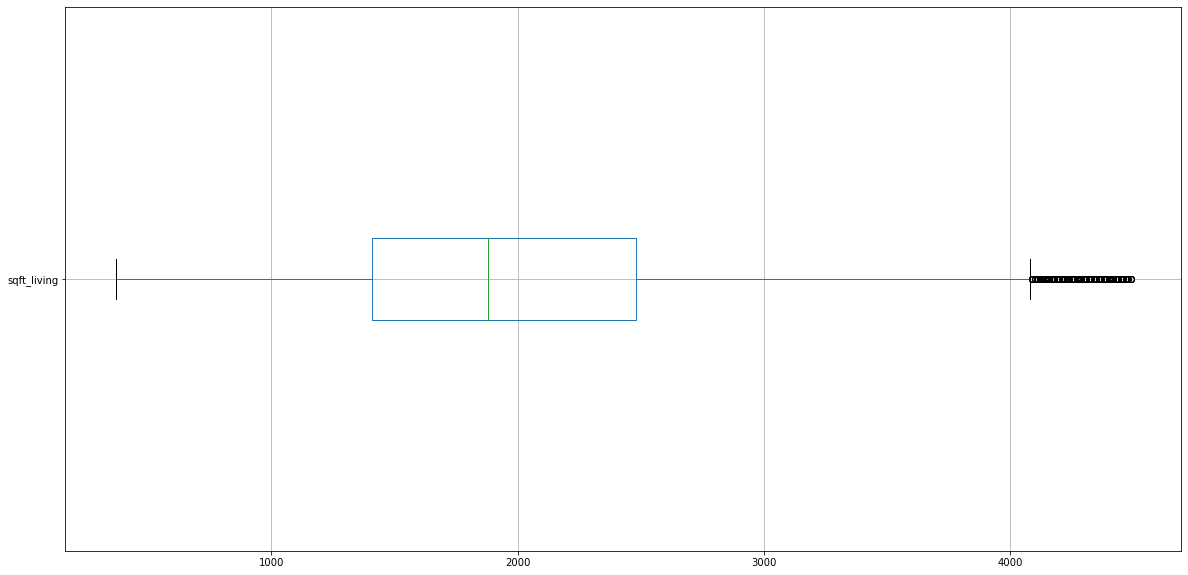

In [1776]:
df.boxplot('sqft_living', vert=False, figsize=(20,10))

<AxesSubplot:>

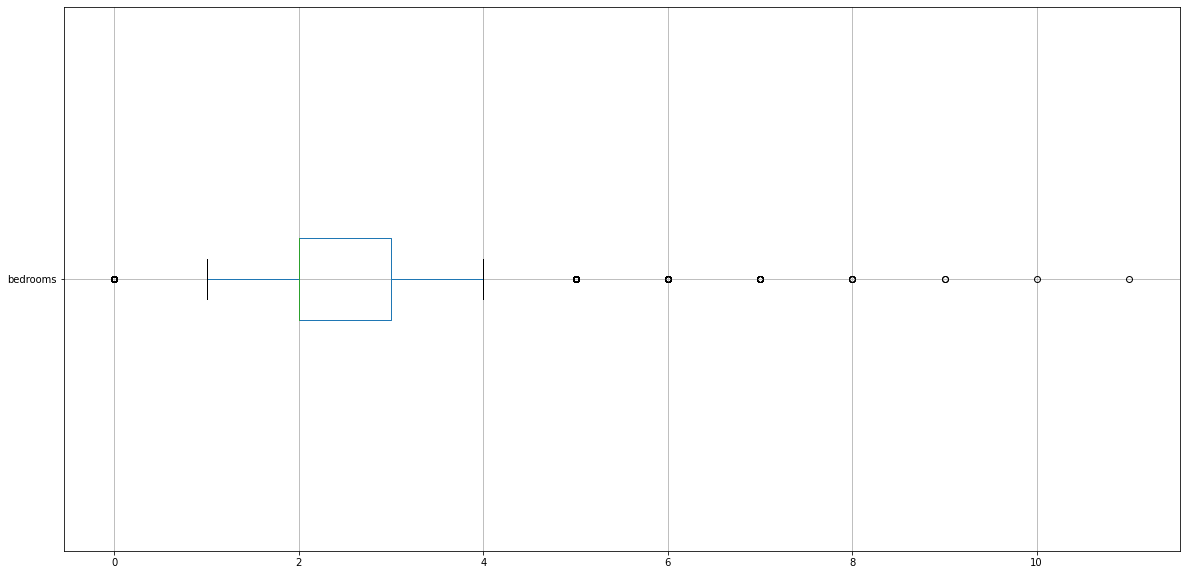

In [1777]:
df.boxplot('bedrooms', vert=False, figsize=(20,10))

In [1778]:
df = (df[df["bedrooms"] < 7])

<AxesSubplot:>

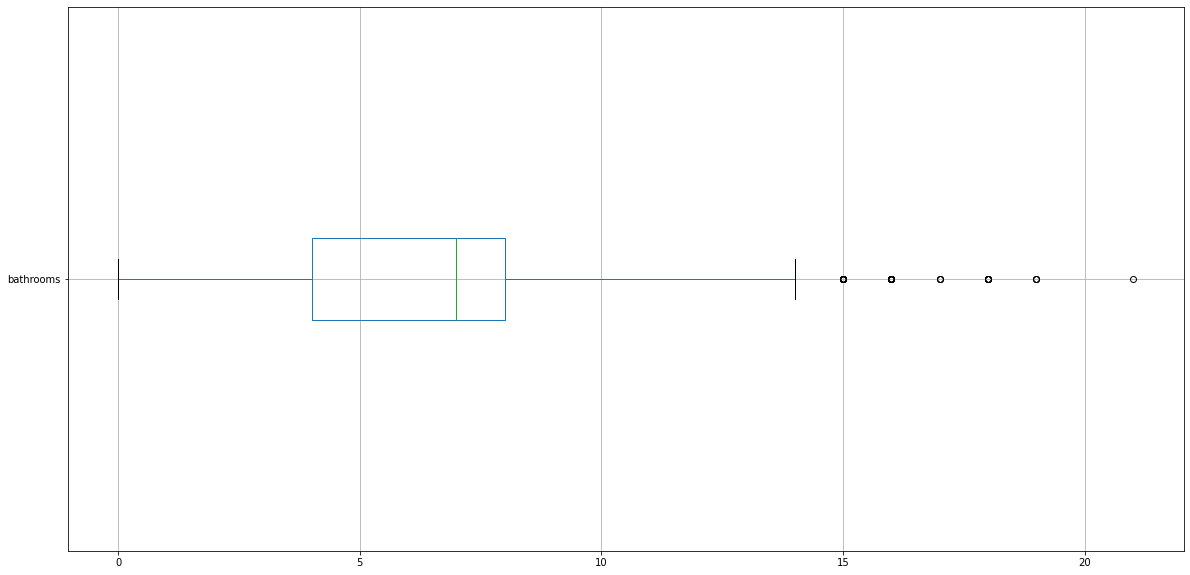

In [1779]:
df.boxplot('bathrooms', vert=False, figsize=(20,10))

In [1780]:
df = (df[df["bathrooms"] < 15])


In [1781]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Income,year_sold,season
count,2.060200e+04,20602.000000,20602.000000,20602.000000,2.060200e+04,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000
mean,4.953211e+05,2.329483,6.227065,1988.832977,1.442505e+04,0.961751,-0.106495,3.746578,0.855111,8.009368,1718.245559,264.912533,1970.754344,63.838220,35.398699,47.558521,-122.214397,1938.146927,12307.690952,145243.577128,2014.325066,1.523007
std,2.388506e+05,0.863913,2.774538,765.304281,3.912709e+04,1.075696,0.319454,0.905942,1.264621,2.007113,722.081119,406.915370,29.283278,351.203133,19.169408,0.140089,0.141573,624.802711,25449.335961,59136.609408,0.468411,1.034936
min,7.800000e+04,0.000000,0.000000,370.000000,5.200000e+02,0.000000,-1.000000,-1.000000,0.000000,0.000000,370.000000,0.000000,1900.000000,0.000000,0.000000,47.155900,-122.519000,399.000000,651.000000,7190.000000,2014.000000,0.000000
25%,3.199500e+05,2.000000,4.000000,1410.000000,5.000000e+03,0.000000,0.000000,4.000000,0.000000,8.000000,1180.000000,0.000000,1951.000000,0.000000,21.000000,47.465025,-122.330000,1480.000000,5040.000000,98510.000000,2014.000000,1.000000
50%,4.425000e+05,2.000000,7.000000,1880.000000,7.500000e+03,0.000000,0.000000,4.000000,0.000000,8.000000,1530.000000,0.000000,1974.000000,0.000000,34.000000,47.569500,-122.233000,1820.000000,7533.000000,141286.000000,2014.000000,1.000000
75%,6.180000e+05,3.000000,8.000000,2460.000000,1.035000e+04,2.000000,0.000000,4.000000,2.000000,9.000000,2120.000000,510.000000,1996.000000,0.000000,52.000000,47.679200,-122.125000,2300.000000,9900.000000,190960.000000,2015.000000,2.000000
max,1.490000e+06,6.000000,14.000000,4490.000000,1.651359e+06,5.000000,1.000000,4.000000,4.000000,10.000000,4480.000000,2220.000000,2015.000000,2015.000000,69.000000,47.777600,-121.315000,5790.000000,560617.000000,277894.000000,2015.000000,3.000000


In [1782]:
#Model with outliers removed
second_model = OLS_reg(df)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     1824.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        01:11:02   Log-Likelihood:            -2.7353e+05
No. Observations:               20602   AIC:                         5.471e+05
Df Residuals:                   20580   BIC:                         5.473e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -9.815e+07   6.49e+06    -15.116

X_train shape (16481, 21)
X_test shape (4121, 21)
y_train shape (16481,)
y_test shape (4121,)
Accuracy R^2 0.6485391277897143
Test_accuracy R^2 0.6573372640643749
Mean Absolute Error: 101002.84853670471
Mean Squared Error: 19277523404.55723
Root Mean Squared Error: 138843.52129126238
      Actual value  Predicted value  Difference
3165      359000.0        450853.43    91853.43
1354      324000.0        298092.59    25907.41
3072      279000.0        291886.12    12886.12
4017      250000.0        395456.04   145456.04
3024      246950.0        426691.55   179741.55
1547      780000.0        671612.38   108387.62
970       218000.0        344381.38   126381.38
1010      520000.0        514087.46     5912.54
3970      425000.0        562905.86   137905.86
1895      357000.0        480099.51   123099.51


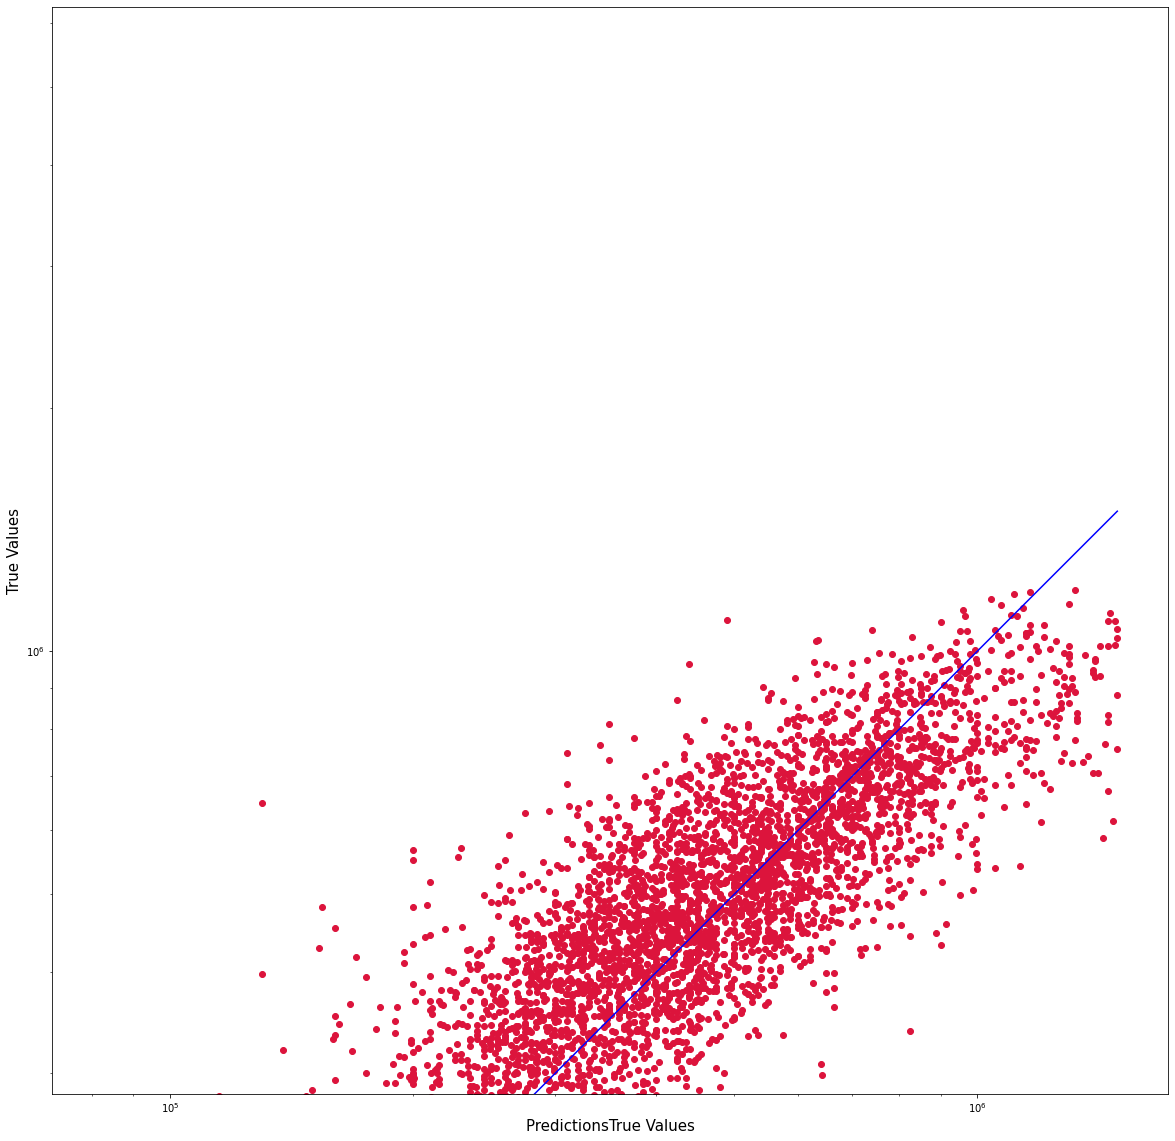

In [1783]:
#Predictive model with outliers removed
predictive_model(df)

In [1784]:
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Income,year_sold,season
0,221900.0,2,2,1180,5650,0,-1,4,0,8,1180,0.0,1955,0.0,66,47.5112,-122.257,1340,5650,113555.0,2014,3
1,205425.0,1,2,880,6780,0,0,4,2,7,880,0.0,1945,0.0,66,47.5009,-122.248,1190,6780,113555.0,2014,1
2,445000.0,2,7,2100,8201,0,-1,0,0,9,1620,480.0,1967,0.0,66,47.5091,-122.244,2660,8712,113555.0,2014,2
3,236000.0,2,2,1300,5898,0,-1,4,0,8,1300,0.0,1961,0.0,66,47.5053,-122.255,1320,7619,113555.0,2014,2
4,170000.0,1,2,860,5265,0,0,4,0,7,860,0.0,1931,0.0,66,47.5048,-122.272,1650,8775,113555.0,2015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21398,1260000.0,2,8,3110,9930,0,0,2,0,9,1640,1470.0,1954,0.0,24,47.6112,-122.226,3650,14399,7190.0,2014,2
21404,1200000.0,3,10,2150,8119,2,0,4,0,9,2150,0.0,1953,2004.0,24,47.6335,-122.236,1590,8119,7190.0,2015,1
21407,1450000.0,4,9,3090,19865,0,0,4,2,10,3090,0.0,1953,0.0,24,47.6232,-122.235,2970,19862,7190.0,2014,3
21410,1350000.0,2,6,2070,9600,0,0,2,0,8,1590,480.0,1946,0.0,24,47.6160,-122.239,3000,16215,7190.0,2014,2


In [1785]:
df_numerical = df[['price', "sqft_living","sqft_lot","sqft_above","sqft_basement","yr_built","lat","long","sqft_living15","sqft_lot15",'Income', 'year_sold']].copy().apply(lambda x: np.log(abs(x+1)))

In [1786]:
df2 =  df[["bedrooms","bathrooms","floors","waterfront","view","condition","season","grade",'zipcode']]

In [1787]:
log_df = pd.concat([df_numerical, df2], axis=1)

In [1788]:
log_df

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,Income,year_sold,bedrooms,bathrooms,floors,waterfront,view,condition,season,grade,zipcode
0,12.309987,7.074117,8.639588,7.074117,0.000000,7.578657,3.881795,4.797912,7.201171,8.639588,11.640051,7.608374,2,2,0,-1,4,0,3,8,66
1,12.232841,6.781058,8.821880,6.781058,0.000000,7.573531,3.881582,4.797838,7.082549,8.821880,11.640051,7.608374,1,2,0,0,4,2,1,7,66
2,13.005832,7.650169,9.012133,7.390799,6.175867,7.584773,3.881751,4.797805,7.886457,9.072571,11.640051,7.608374,2,7,0,-1,0,0,2,9,66
3,12.371591,7.170888,8.682538,7.170888,0.000000,7.581720,3.881673,4.797896,7.186144,8.938532,11.640051,7.608374,2,2,0,-1,4,0,2,8,66
4,12.043560,6.758095,8.569026,6.758095,0.000000,7.566311,3.881663,4.798036,7.409136,9.079776,11.640051,7.608871,1,2,0,0,4,0,0,7,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21398,14.046623,8.042699,9.203416,7.403061,7.293698,7.578145,3.883854,4.797657,8.202756,9.574983,8.880586,7.608374,2,8,0,0,2,0,2,9,24
21404,13.997833,7.673688,9.002085,7.673688,0.000000,7.577634,3.884313,4.797739,7.372118,9.002085,8.880586,7.608871,3,10,2,0,4,0,1,9,24
21407,14.187075,8.036250,9.896765,8.036250,0.000000,7.577634,3.884101,4.797731,7.996654,9.896614,8.880586,7.608374,4,9,0,0,4,2,3,10,24
21410,14.115616,7.635787,9.169623,7.372118,6.175867,7.574045,3.883953,4.797764,8.006701,9.693754,8.880586,7.608374,2,6,0,0,2,0,2,8,24


In [1789]:
#Log transformed 
OLS_reg(log_df)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     2279.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        01:11:02   Log-Likelihood:                -1480.9
No. Observations:               20602   AIC:                             3004.
Df Residuals:                   20581   BIC:                             3170.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1027.4425     89.923    -11.426

X_train shape (16481, 20)
X_test shape (4121, 20)
y_train shape (16481,)
y_test shape (4121,)
Accuracy R^2 0.6893188062005156
Test_accuracy R^2 0.686720957744408
Mean Absolute Error: 0.20096534819361747
Mean Squared Error: 0.06715265815634772
Root Mean Squared Error: 0.25913829928504917
      Actual value  Predicted value  Difference
2496     13.717899            13.30        0.42
792      12.254868            12.51        0.25
1075     12.971310            13.30        0.33
3650     12.936036            13.17        0.23
1504     12.560248            12.62        0.06
1326     13.169153            12.98        0.19
2686     14.144815            13.60        0.55
4119     12.562876            12.92        0.35
2303     13.038984            12.85        0.19
2233     12.690044            12.92        0.23


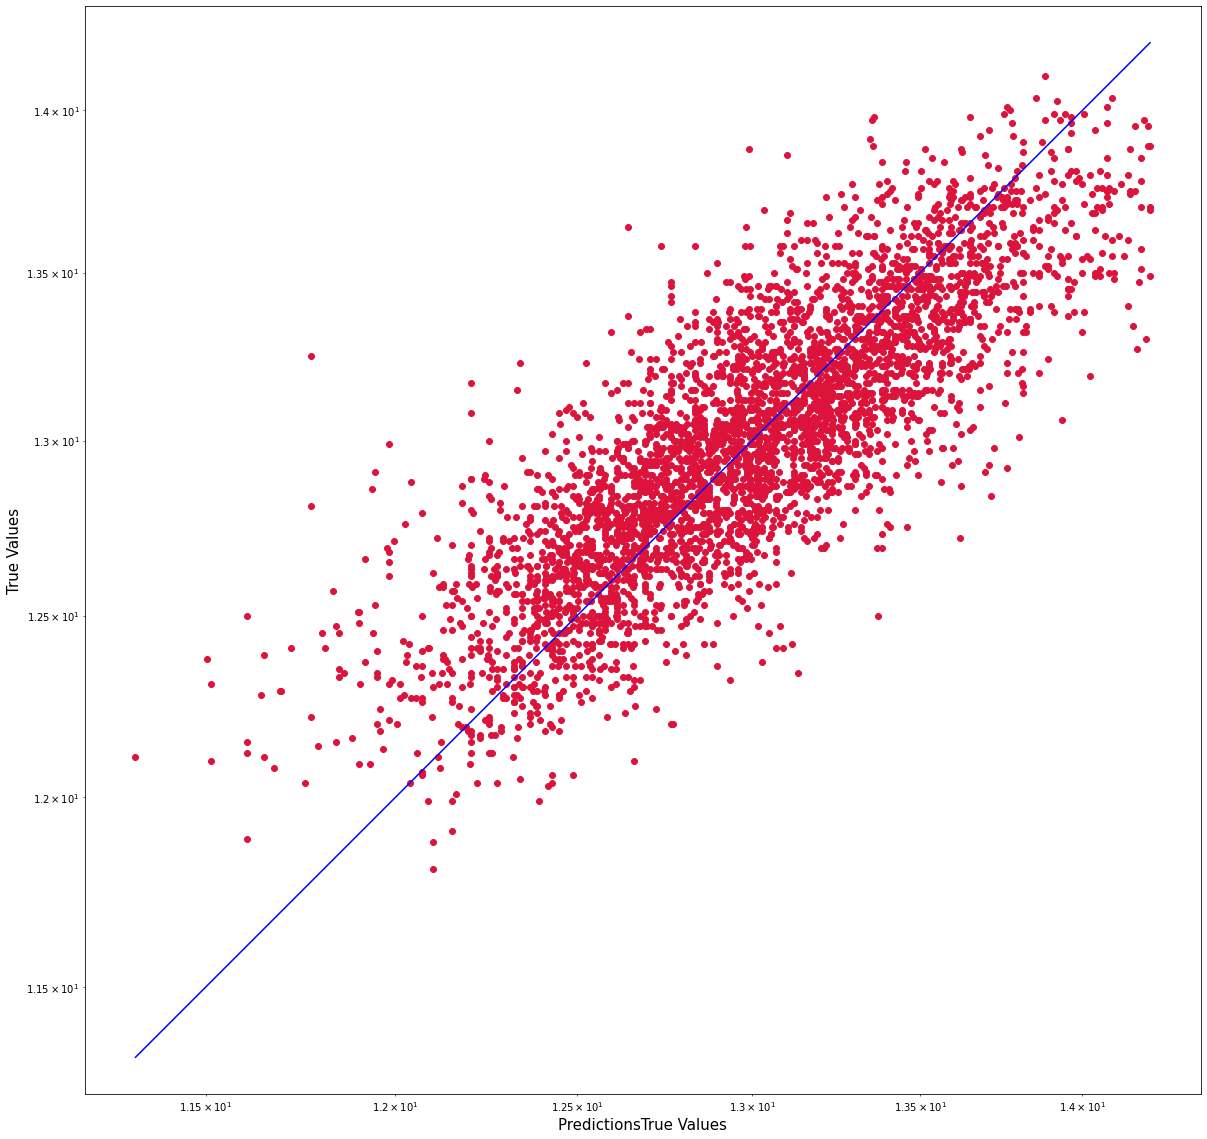

In [1790]:
predictive_model(log_df)

In [1791]:
poly_model(log_df)

degree 2 0.7902581587672995
degree 3 0.8251454914223305


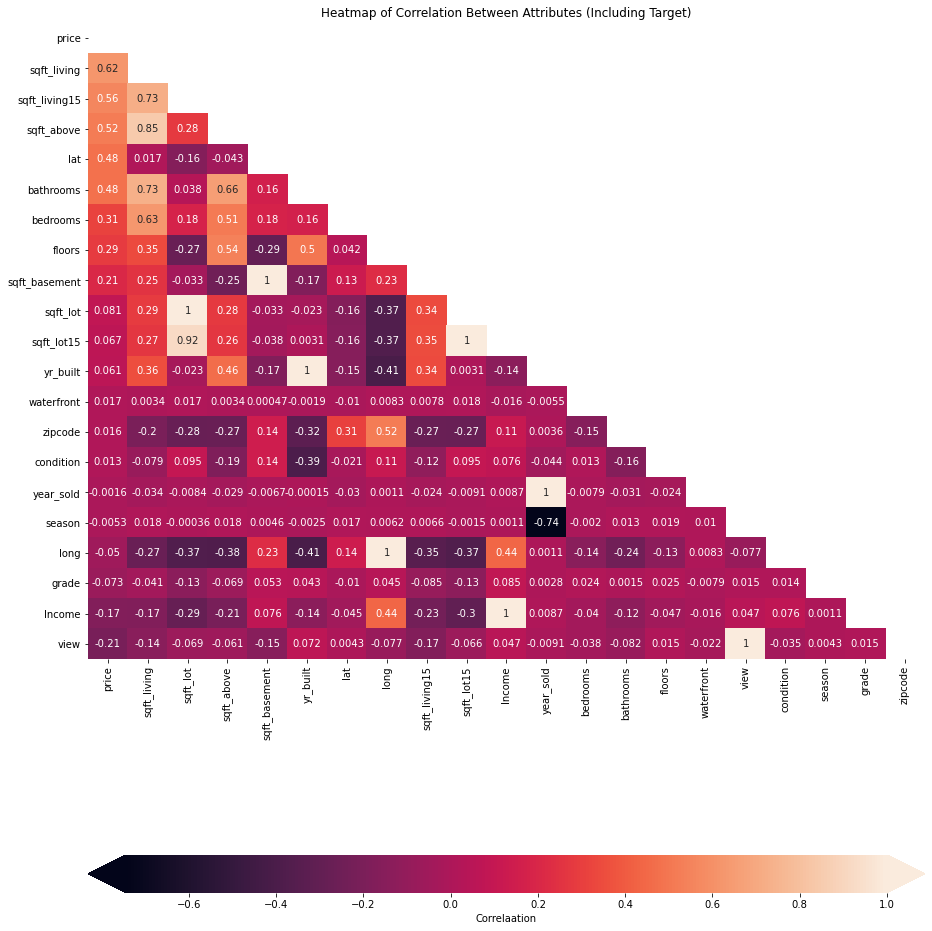

In [1792]:
initial_corr = log_df.corr().sort_values(by="price", ascending=False)
fig, ax = plt.subplots(figsize=(15,18))
sns.heatmap(data = initial_corr, mask = np.triu(np.ones_like(initial_corr, dtype=bool)), ax = ax, annot = True, cbar_kws = {"label": "Correlaation", "orientation": "horizontal", "pad": .2, "extend": "both"})

ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [1793]:
#Feature selection
df_selection = df[["price",'sqft_living', 'lat','bedrooms','bathrooms','floors',"view"]]

In [1794]:
OLS_reg(df_selection)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     4741.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        01:11:09   Log-Likelihood:            -2.7542e+05
No. Observations:               20602   AIC:                         5.509e+05
Df Residuals:                   20595   BIC:                         5.509e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3.104e+07   3.67e+05    -84.510      

X_train shape (16481, 6)
X_test shape (4121, 6)
y_train shape (16481,)
y_test shape (4121,)
Accuracy R^2 0.5781141744093249
Test_accuracy R^2 0.5873564286730362
Mean Absolute Error: 110104.70579141524
Mean Squared Error: 23214505896.812943
Root Mean Squared Error: 152363.0726154239
      Actual value  Predicted value  Difference
2313      389000.0        431736.81    42736.81
386       469950.0        446744.83    23205.17
1690      190000.0        275038.64    85038.64
1753     1280000.0        873795.52   406204.48
3557      186375.0        228956.97    42581.97
3502      678000.0        730004.82    52004.82
2054      615000.0        469654.28   145345.72
156       250000.0        519937.39   269937.39
958       995000.0        690198.27   304801.73
819       410000.0        430052.27    20052.27


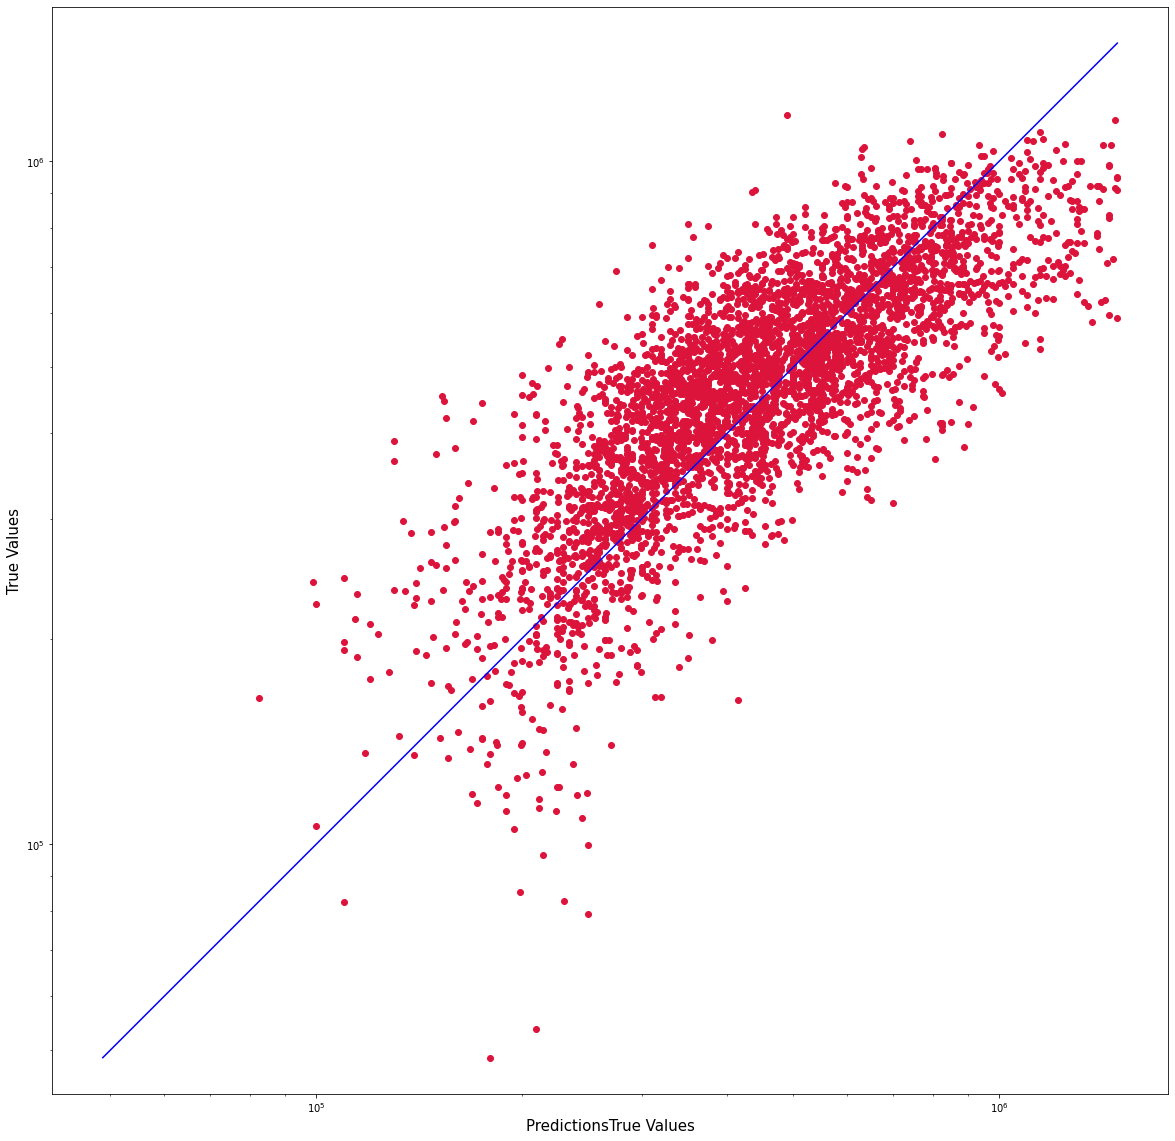

In [1795]:
predictive_model(df_selection)

In [1796]:
poly_model(df_selection)

degree 2 0.6275525974802507
degree 3 0.6376527674057184
